## Query Vector Database

#### Set environment variables

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

aoai_endpoint  = os.getenv("AZURE_OPENAI_ENDPOINT")
if aoai_endpoint is None or aoai_endpoint == "":
    print("AZURE_OPENAI_ENDPOINT environment variable not set.")
    exit(1)

aoai_api_version  = os.getenv("AZURE_OPENAI_API_VERSION")
if aoai_api_version is None or aoai_api_version == "":
    print("AZURE_OPENAI_API_VERSION environment variable not set.")
    exit(1)

aoai_embedding_deployed_model  = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL")
if aoai_embedding_deployed_model is None or aoai_embedding_deployed_model == "":
    print("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL environment variable not set.")
    exit(1)

aoai_key  = os.getenv("AZURE_OPENAI_KEY")
if aoai_key is None or aoai_key == "":
    print("AZURE_OPENAI_KEY environment variable not set.")
    exit(1)

ai_search_endpoint  = os.getenv("AI_SEARCH_ENDPOINT")
if ai_search_endpoint is None or ai_search_endpoint == "":
    print("AI_SEARCH_ENDPOINT environment variable not set.")
    exit(1)

ai_search_api_version  = os.getenv("AI_SEARCH_API_VERSION")
if ai_search_api_version is None or ai_search_api_version == "":
    print("AI_SEARCH_API_VERSION environment variable not set.")
    exit(1)

ai_search_key  = os.getenv("AI_SEARCH_KEY")
if ai_search_key is None or ai_search_key == "":
    print("AI_SEARCH_KEY environment variable not set.")
    exit(1)

com_vision_endpoint  = os.getenv("COM_VISION_ENDPOINT")
if com_vision_endpoint is None or com_vision_endpoint == "":
    print("COM_VISION_ENDPOINT environment variable not set.")
    exit(1)

com_vision_api_version  = os.getenv("COM_VISION_API_VERSION")
if com_vision_api_version is None or com_vision_api_version == "":
    print("COM_VISION_API_VERSION environment variable not set.")
    exit(1)

com_vision_key  = os.getenv("COMPUTER_VISION_KEY")
if com_vision_key is None or com_vision_key == "":
    print("COMPUTER_VISION_KEY environment variable not set.")
    exit(1)

index_prefix = os.getenv("INDEX_PREFIX")
if index_prefix is None or index_prefix == "":
    print("INDEX_PREFIX environment variable not set.")
    exit(1)

grocery_index = f"{index_prefix}_grocery"
grocery_image_index = f"{index_prefix}_grocery_image"

#### Simple full-text search

In [2]:
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient  

azure_oai_client = AzureOpenAI(
  api_key = aoai_key,  
  api_version = aoai_api_version,
  azure_endpoint = aoai_endpoint
)

query = 'cow meat'

search_client = SearchClient(ai_search_endpoint, grocery_index, AzureKeyCredential(ai_search_key))

results = search_client.search(
    search_text=query,
    select=["product_name"],
    top=5
)

for result in results:
    print(f"{result['product_name']}")

ServiceRequestError: <urllib3.connection.HTTPSConnection object at 0x00000215A1EBACE0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed

#### Simple vector search

In [4]:
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient  
from azure.search.documents.models import VectorizedQuery

query = 'cattle'

azure_oai_client = AzureOpenAI(
  api_key = aoai_key,  
  api_version = aoai_api_version,
  azure_endpoint = aoai_endpoint
)

query_vector = azure_oai_client.embeddings.create(input = [query], model=aoai_embedding_deployed_model).data[0].embedding

search_client = SearchClient(ai_search_endpoint, grocery_index, AzureKeyCredential(ai_search_key))

vector_query = VectorizedQuery(vector=query_vector, k_nearest_neighbors=5, fields="product_name_vector")

results = search_client.search(
    search_text=None,
    vector_queries=[vector_query],
    select=["product_name"],
    top=5
)

for result in results:
    print(f"{result['product_name']}")

Graze Grassfed Beef Diced Steak
Graze Grassfed Beef Diced Steak
Graze Grass Fed Beef Mince
Graze Grass Fed Beef Mince
Graze Grass Fed Beef Mince


#### Simple vector search with metadata filtering

In [6]:
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient  
from azure.search.documents.models import VectorizedQuery

query = 'egg'

azure_oai_client = AzureOpenAI(
  api_key = aoai_key,  
  api_version = aoai_api_version,
  azure_endpoint = aoai_endpoint
)

query_vector = azure_oai_client.embeddings.create(input = [query], model=aoai_embedding_deployed_model).data[0].embedding

search_client = SearchClient(ai_search_endpoint, grocery_index, AzureKeyCredential(ai_search_key))

vector_query = VectorizedQuery(vector=query_vector, k_nearest_neighbors=10, fields="product_name_vector")

results = search_client.search(
    search_text=None,
    vector_queries=[vector_query],
    filter="sub_category eq 'Beef & veal'",
    select=["product_name"],
    top=5
)

for result in results:
    print(f"{result['product_name']}")

Veal Fillet Whole
Diced Casserole
Beef Eye Fillet Roast
Beef Eye Fillet Steak
Beef Gravy


#### Hybrid search

In [7]:
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient  
from azure.search.documents.models import VectorizedQuery

query = 'beef'

azure_oai_client = AzureOpenAI(
  api_key = aoai_key,  
  api_version = aoai_api_version,
  azure_endpoint = aoai_endpoint
)

query_vector = azure_oai_client.embeddings.create(input = [query], model=aoai_embedding_deployed_model).data[0].embedding

search_client = SearchClient(ai_search_endpoint, grocery_index, AzureKeyCredential(ai_search_key))

vector_query = VectorizedQuery(vector=query_vector, k_nearest_neighbors=10, fields="product_name_vector")

results = search_client.search(
    search_text=query,
    vector_queries=[vector_query],
    select=["product_name"],
    top=5
)

for result in results:
    print(f"{result['product_name']}")

Beef Ribs
Beef Rump Steak
Beef Diced
Beef Ribs
Beef T Bone Steak


#### Image search

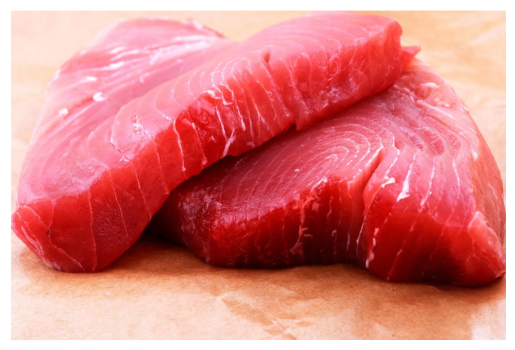

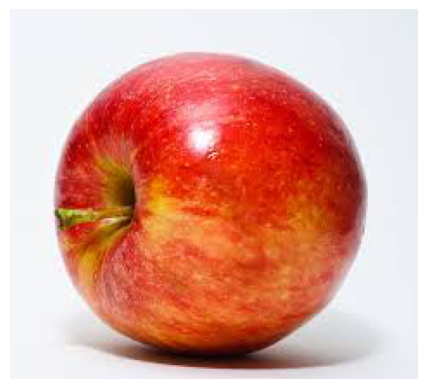

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from azure.search.documents.models import VectorizedQuery

def vectorize_text_com_vision(com_vision_endpoint,com_vision_key,query):
    vectorize_text_url = f"{com_vision_endpoint}/computervision/retrieval:vectorizeText"  
    params = {  
        "api-version": com_vision_api_version  
    } 
    headers = {  
        "Content-Type": "application/json",  
        "Ocp-Apim-Subscription-Key": com_vision_key  
    }  
    data = {
        'text': query
    }

    response = requests.post(vectorize_text_url, params=params, headers=headers, json=data)
    query_vector = response.json()["vector"]

    return query_vector

def show_image(image_folder, image):
    image_path = os.path.join(image_folder, image)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.show()

query = 'fish'
image_folder = "data/images"

query_vector = vectorize_text_com_vision(com_vision_endpoint,com_vision_key,query)

search_client = SearchClient(ai_search_endpoint, grocery_image_index, AzureKeyCredential(ai_search_key))
vector_query = VectorizedQuery(exhaustive=True,vector=query_vector, k_nearest_neighbors=10, fields="image_vector")

results = search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["image"],
    top = 2
)  

for result in results:
    show_image(image_folder, result['image'])
    print("\n")